<a href="https://colab.research.google.com/github/ppokranguser/Artificial_Intelligence_study/blob/main/transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CAU-AI Assignment3

### Environment

In [ ]:
!apt install python3.7
!pip install -U torchtext==0.6.0
!python -m spacy download de_core_news_sm
!python -m spacy download en_core_web_sm

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3.7 is already the newest version (3.7.17-1+jammy1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 26.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 35.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selec

In [ ]:
# Unzip the data
!unzip multi30k.zip

Archive:  multi30k.zip
replace multi30k/test2016.de? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import torch
import torch.nn as nn

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import spacy
import math
import time
import numpy as np
import matplotlib.pyplot as plt

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Seed
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

### Dataset

Tokenizer

In [ ]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [ ]:
def tokenize_de(text):
  return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
  return [tok.text for tok in spacy_en.tokenizer(text)]

In [ ]:
SRC = Field(
    tokenize=tokenize_de,
    init_token='<sos>',
    eos_token='<eos>',
    lower=True,
    batch_first=True
)
TRG = Field(
    tokenize=tokenize_en,
    init_token='<sos>',
    eos_token='<eos>',
    lower=True,
    batch_first=True
)

Split

In [ ]:
# Split the Multi30k dataset into training, validation, and test sets
train_data, val_data, test_data = Multi30k.splits(exts=('.de', '.en'), fields=(SRC, TRG), root='./')

In [ ]:
# Number of data
print(f"Number of train data: {len(train_data.examples)}")
print(f"Number of val data: {len(val_data.examples)}")
print(f"Number of test data: {len(test_data.examples)}")

Number of train data: 29000
Number of val data: 1014
Number of test data: 1000


In [ ]:
# Examples of data
examples = np.random.randint(len(train_data.examples), size=5)
for idx in examples:
  print(f"{vars(train_data.examples[idx])}")

{'src': ['ein', 'junge', 'mit', 'einem', 'blauen', 'handtuch', 'und', 'einem', 'weißen', 'hut', 'hält', 'eine', 'taucherbrille', 'und', 'einen', 'schnorchel', '.'], 'trg': ['boy', 'with', 'a', 'blue', 'towel', 'and', 'white', 'hat', 'holding', 'goggles', 'and', 'a', 'snokel', '.']}
{'src': ['ein', 'schwarz-weißer', 'hund', 'springt', 'auf', 'der', 'wiese', '.'], 'trg': ['a', 'black', 'and', 'white', 'dog', 'is', 'jumping', 'in', 'the', 'grass', '.']}
{'src': ['zwei', 'männer', 'in', 'schwarzen', 'hemden', ',', 'die', 'jeweils', 'auf', 'einem', 'arm', 'stehen', '.'], 'trg': ['two', 'men', 'in', 'black', 'shirts', 'each', 'standing', 'on', 'one', 'arm', '.']}
{'src': ['ein', 'kind', 'mit', 'schwimmbrille', ',', 'das', 'vor', 'einem', 'schwimmbecken', 'in', 'ein', 'handtuch', 'eingewickelt', 'ist', ',', 'weint', '.'], 'trg': ['a', 'child', 'wearing', 'goggles', 'and', 'wrapped', 'in', 'a', 'towel', 'is', 'crying', 'in', 'front', 'of', 'a', 'pool', '.']}
{'src': ['ein', 'mann', 'in', 'eine

Vocabulary

In [ ]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [ ]:
# Vocabulary size
print(f"Source vocab size (de): {len(SRC.vocab)}")
print(f"Target vocab size (en): {len(TRG.vocab)}")

Source vocab size (de): 7853
Target vocab size (en): 5893


In [ ]:
# Token index
print(f"<unk> token: {TRG.vocab.stoi['abc']}")
print(f"<pad> token: {TRG.vocab.stoi[TRG.pad_token]}")
print(f"<sos> token: {TRG.vocab.stoi['<sos>']}")
print(f"<eos> token: {TRG.vocab.stoi['<eos>']}")
print(f"happy: {TRG.vocab.stoi['happy']}")

<unk> token: 0
<pad> token: 1
<sos> token: 2
<eos> token: 3
happy: 667


Iterator

In [ ]:
# "Tune" part
BATCH_SIZE = 64 # to be tuned by yourself

train_iter, val_iter, test_iter = BucketIterator.splits(
    (train_data, val_data, test_data),
    batch_size=BATCH_SIZE,
    device=device
)

In [ ]:
# Examples of input and output
for iter, batch in enumerate(train_iter):
    src = batch.src
    trg = batch.trg

    print(f"src: {src[0]}")
    print(f"trg: {trg[0]}\n")

    if iter == 2:
        break

src: tensor([   2,    8, 4092,  512, 5860,   12,    8, 2173,    9,   35,   15,    0,
           0,    9,   33,   92,   28,  324,    4,    3,    1,    1,    1,    1,
           1], device='cuda:0')
trg: tensor([   2,    4,  183,  945,  105, 3390, 1345,   69,    4,  742,   58,    7,
        2943,   89, 3580,   18,  366,    7,   68,    5,    3,    1,    1,    1,
           1,    1,    1,    1,    1], device='cuda:0')

src: tensor([   2,    5,  171,   32,   37,   75,  747, 4941,    7,  197,  762,    4,
           3,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1], device='cuda:0')
trg: tensor([  2,   4,  61,  35,   6,   7,  95, 136, 121, 600,  90,   6, 227, 203,
          5,   3,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1], device='cuda:0')

src: tensor([  2,   5,  25,  11,   6,  51,  79,  10, 102, 219,  38, 816,   4,   3,
          1,   1,   1,   1,   1,   1,   1,   1,   1], devi

### Model

Multi-Head Attention

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_dim, n_heads, dropout):
        super(MultiHeadAttention, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_heads = n_heads
        self.head_dim = hidden_dim // n_heads

        self.fc_q = nn.Linear(hidden_dim, hidden_dim)
        self.fc_k = nn.Linear(hidden_dim, hidden_dim)
        self.fc_v = nn.Linear(hidden_dim, hidden_dim)
        self.fc_o = nn.Linear(hidden_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, query, key, value, mask=None):
        """
        Perform Multi-Head Attention with Scaled Dot-Product Attention.
        """
        batch_size = query.size(0)

        # Linear projections for query, key, and value
        Q = self.fc_q(query)  # Shape: (batch_size, q_len, hidden_dim)
        K = self.fc_k(key)    # Shape: (batch_size, k_len, hidden_dim)
        V = self.fc_v(value)  # Shape: (batch_size, v_len, hidden_dim)

        # Reshape and permute to (batch_size, n_heads, seq_len, head_dim)
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        # Scaled dot-product attention with learnable scale
        scale = nn.Parameter(torch.tensor(self.head_dim ** 0.5, requires_grad=True, device=query.device))
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / scale

        # Apply mask (if provided)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)  # 부드럽게 조정

        # Attention probabilities
        attn_probs = self.softmax(attn_scores)
        attn_probs = self.dropout(attn_probs)

        # Weighted sum of values
        attn_output = torch.matmul(attn_probs, V)  # Shape: (batch_size, n_heads, q_len, head_dim)

        # Concatenate heads and project back
        attn_output = attn_output.permute(0, 2, 1, 3).contiguous()
        attn_output = attn_output.view(batch_size, -1, self.hidden_dim)
        output = self.fc_o(attn_output)  # Shape: (batch_size, q_len, hidden_dim)

        return output, attn_probs


Position-wise Feed-Forward Network

In [ ]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, hidden_dim, ffn_dim, dropout):
        super(PositionwiseFeedForward, self).__init__()

        self.fc_1 = nn.Linear(hidden_dim, ffn_dim)
        self.fc_2 = nn.Linear(ffn_dim, hidden_dim)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Perform Position-wise Feed-Forward Network.
        """
        x = self.fc_1(x)  # Shape: (batch_size, seq_len, ffn_dim)
        x = self.relu(x) * torch.sigmoid(x)  # Swish 적용
        x = self.dropout(x)  # Apply dropout
        x = self.fc_2(x)  # Shape: (batch_size, seq_len, hidden_dim)
        return x



Positional Encoding

In [ ]:
def PositionalEncoding(hidden_dim, seq_len):
    positional_encoding = torch.zeros((seq_len, hidden_dim))

    pos = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)

    _2i = torch.arange(0, hidden_dim, step=2, dtype=torch.float)

    positional_encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / hidden_dim)))
    positional_encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / hidden_dim)))

    pos_enc = positional_encoding.unsqueeze(0)

    return pos_enc

Encoder Layer

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, ffn_dim, dropout):
        super(EncoderLayer, self).__init__()

        self.self_attention = MultiHeadAttention(hidden_dim, n_heads, dropout)
        self.norm_1 = nn.LayerNorm(hidden_dim)

        self.ffn = PositionwiseFeedForward(hidden_dim, ffn_dim, dropout)
        self.norm_2 = nn.LayerNorm(hidden_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Self-Attention
        _x, _ = self.self_attention(x, x, x, mask)
        x = self.norm_1(x + self.dropout(_x))

        # Feed Forward Network
        _x = self.ffn(x)
        x = self.norm_2(x + self.dropout(_x))

        return x

Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, n_heads, ffn_dim, max_len, dropout):
        super(Encoder, self).__init__()

        self.src_emb = nn.Embedding(input_dim, hidden_dim)

        self.hidden_dim = hidden_dim

        self.layers = nn.ModuleList([EncoderLayer(hidden_dim, n_heads, ffn_dim, dropout) for _ in range(n_layers)])

        self.dropout = nn.Dropout(dropout)

        self.scale = math.sqrt(hidden_dim)

    def forward(self, x, mask=None):
        batch_size, seq_len = x.size()

        pos_enc = PositionalEncoding(self.hidden_dim, seq_len).to(x.device)
        x = self.dropout((self.src_emb(x) * self.scale) + pos_enc)

        for layer in self.layers:
            x = layer(x, mask)

        return x

Decoder Layer

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, ffn_dim, dropout):
        super(DecoderLayer, self).__init__()

        self.self_attention = MultiHeadAttention(hidden_dim, n_heads, dropout)
        self.norm_1 = nn.LayerNorm(hidden_dim)

        self.enc_dec_attention = MultiHeadAttention(hidden_dim, n_heads, dropout)
        self.norm_2 = nn.LayerNorm(hidden_dim)

        self.ffn = PositionwiseFeedForward(hidden_dim, ffn_dim, dropout)
        self.norm_3 = nn.LayerNorm(hidden_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, trg_mask=None, src_mask=None):
        # Self-Attention
        _x, _ = self.self_attention(x, x, x, trg_mask)
        x = self.norm_1(x + self.dropout(_x))

        # Encoder-Decoder Attention
        _x, attn = self.enc_dec_attention(x, enc_output, enc_output, src_mask)
        x = self.norm_2(x + self.dropout(_x))

        # Feed Forward Network
        _x = self.ffn(x)
        x = self.norm_3(x + self.dropout(_x))

        return x, attn

Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, n_layers, n_heads, ffn_dim, max_len, dropout):
        super(Decoder, self).__init__()

        self.trg_emb = nn.Embedding(output_dim, hidden_dim)

        self.hidden_dim = hidden_dim

        self.layers = nn.ModuleList([DecoderLayer(hidden_dim, n_heads, ffn_dim, dropout) for _ in range(n_layers)])

        self.fc_out = nn.Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

        self.scale = math.sqrt(hidden_dim)

    def forward(self, x, enc_output, trg_mask=None, src_mask=None):
        batch_size, seq_len = x.size()

        pos_enc = PositionalEncoding(self.hidden_dim, seq_len).to(x.device)
        x = self.dropout((self.trg_emb(x) * self.scale) + pos_enc)

        for layer in self.layers:
            x, attn = layer(x, enc_output, trg_mask, src_mask)

        output = self.fc_out(x)

        return output, attn

Transformer

In [ ]:
class Transformer(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, n_layers, n_heads, ffn_dim, max_len, dropout, src_pad_idx, trg_pad_idx, device):
        super(Transformer, self).__init__()

        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx

        self.device = device

        self.encoder = Encoder(input_dim, hidden_dim, n_layers, n_heads, ffn_dim, max_len, dropout)
        self.decoder = Decoder(output_dim, hidden_dim, n_layers, n_heads, ffn_dim, max_len, dropout)

    def pad_mask(self, src, trg, src_pad_idx, trg_pad_idx):
        src_mask = (src != src_pad_idx).unsqueeze(1).unsqueeze(2)
        trg_mask = (trg != trg_pad_idx).unsqueeze(1).unsqueeze(3)
        trg_mask = trg_mask & self.subsequent_mask(trg_mask.shape[2])
        return src_mask, trg_mask

    def subsequent_mask(self, seq_len):
        sub_mask = torch.tril(torch.ones((seq_len, seq_len), dtype=torch.long)).to(self.device)
        return sub_mask

    def forward(self, src, trg):
        src_mask, trg_mask = self.pad_mask(src, trg, self.src_pad_idx, self.trg_pad_idx)

        enc_output = self.encoder(src, mask=src_mask)
        output, attn = self.decoder(trg, enc_output, trg_mask=trg_mask, src_mask=src_mask)

        return output, attn

### Training

Hyperparameter

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
MAX_LEN = 100

SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

# Tune
HIDDEN_DIM = 256
N_LAYERS = 2
N_HEADS = 4
FFN_DIM = 4096
DROPOUT = 0.1

In [ ]:
# Tune
EPOCH = 40
LEARNING_RATE = 4.932830179027451e-05

Utils

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def initialize_weights(model):
    if hasattr(model, 'weight') and model.weight.dim() > 1:
        nn.init.xavier_uniform_(model.weight.data)

def idx_to_word(token, vocab):
    sentence = []
    for t in token:
        if t > 3:
            sentence.append(vocab.itos[t])

    return sentence

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))

    return elapsed_mins, elapsed_secs

Train

In [ ]:
def train(model, train_iter, optimizer, criterion):
    model.train()
    train_loss = 0
    for _, batch in enumerate(train_iter):
        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        output, _ = model(src, trg[:,:-1])
        output = output.contiguous().view(-1, output.shape[-1])
        trg = trg[:,1:].contiguous().view(-1)

        loss = criterion(output, trg)
        train_loss += loss.item() / len(train_iter)

        loss.backward()
        optimizer.step()

    return train_loss

Evaluation

In [ ]:
def eval(model, eval_iter, criterion):
    model.eval()
    eval_loss = 0
    with torch.no_grad():
        for _, batch in enumerate(eval_iter):
            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            output = output.contiguous().view(-1, output.shape[-1])
            trg = trg[:,1:].contiguous().view(-1)

            loss = criterion(output, trg)
            eval_loss += loss.item() / len(eval_iter)

    return eval_loss

Train & Val

In [ ]:
model = Transformer(
    input_dim=INPUT_DIM,
    output_dim=OUTPUT_DIM,
    hidden_dim=HIDDEN_DIM,
    n_layers=N_LAYERS,
    n_heads=N_HEADS,
    ffn_dim=FFN_DIM,
    max_len=MAX_LEN,
    dropout=DROPOUT,
    src_pad_idx=SRC_PAD_IDX,
    trg_pad_idx=TRG_PAD_IDX,
    device=device
).to(device)

print(f"The model has {count_parameters(model):,} trainable parameters.")

model.apply(initialize_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

The model has 15,023,621 trainable parameters.


In [ ]:
# Train & Val
best_loss = 999.
for epoch in range(EPOCH):
    start_time = time.time()

    train_loss = train(model, train_iter, optimizer, criterion)
    val_loss = eval(model, val_iter, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')

    print(f"Epoch: {epoch+1} | Time: {epoch_mins}m {epoch_secs}s")
    print(f"\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}")
    print(f"\tVal Loss: {val_loss:.3f} | Val PPL: {math.exp(val_loss):7.3f}")

Epoch: 1 | Time: 0m 27s
	Train Loss: 5.733 | Train PPL: 308.795
	Val Loss: 4.475 | Val PPL:  87.793
Epoch: 2 | Time: 0m 25s
	Train Loss: 4.223 | Train PPL:  68.252
	Val Loss: 3.646 | Val PPL:  38.331
Epoch: 3 | Time: 0m 25s
	Train Loss: 3.623 | Train PPL:  37.461
	Val Loss: 3.171 | Val PPL:  23.837
Epoch: 4 | Time: 0m 25s
	Train Loss: 3.249 | Train PPL:  25.759
	Val Loss: 2.866 | Val PPL:  17.558
Epoch: 5 | Time: 0m 25s
	Train Loss: 2.976 | Train PPL:  19.610
	Val Loss: 2.646 | Val PPL:  14.102
Epoch: 6 | Time: 0m 25s
	Train Loss: 2.763 | Train PPL:  15.846
	Val Loss: 2.484 | Val PPL:  11.988
Epoch: 7 | Time: 0m 25s
	Train Loss: 2.591 | Train PPL:  13.343
	Val Loss: 2.344 | Val PPL:  10.419
Epoch: 8 | Time: 0m 27s
	Train Loss: 2.443 | Train PPL:  11.511
	Val Loss: 2.240 | Val PPL:   9.393
Epoch: 9 | Time: 0m 26s
	Train Loss: 2.313 | Train PPL:  10.109
	Val Loss: 2.139 | Val PPL:   8.490
Epoch: 10 | Time: 0m 25s
	Train Loss: 2.200 | Train PPL:   9.029
	Val Loss: 2.060 | Val PPL:   7.845

Test

In [ ]:
# Test
model.load_state_dict(torch.load('best_model.pt'))
model.to(device)

<ipython-input-35-c32c25916694>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


Transformer(
  (encoder): Encoder(
    (src_emb): Embedding(7853, 256)
    (layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (self_attention): MultiHeadAttention(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (softmax): Softmax(dim=-1)
        )
        (norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ffn): PositionwiseFeedForward(
          (fc_1): Linear(in_features=256, out_features=4096, bias=True)
          (fc_2): Linear(in_features=4096, out_features=256, bias=True)
          (relu): ReLU()
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (norm_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0

In [ ]:
# Test
test_loss = eval(model, test_iter, criterion)
print(f"\tTest Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f}")

	Test Loss: 1.624 | Test PPL:   5.072


### Inference

Translation

In [ ]:
def machine_translation(sentence, SRC, TRG, model, device, max_len=50):
    model.eval()

    if isinstance(sentence, list):
      sentence = " ".join(sentence)
      token = tokenize_de(sentence)
      token = [SRC.init_token] + token + [SRC.eos_token]

      src = [SRC.vocab.stoi[tok] for tok in token]
      src = torch.tensor(src, dtype=torch.long).unsqueeze(0).to(device)
    else:
      src = sentence.unsqueeze(0)

    src_mask = (src != model.src_pad_idx).unsqueeze(1).unsqueeze(2)

    with torch.no_grad():
        enc_output = model.encoder(src, mask=src_mask)

    trg_idx = [TRG.vocab.stoi[TRG.init_token]]
    trg_idx = torch.tensor(trg_idx, dtype=torch.long).unsqueeze(0).to(device)

    for _ in range(max_len):
        trg_mask = (trg_idx != model.trg_pad_idx).unsqueeze(1).unsqueeze(3)
        trg_mask = trg_mask & model.subsequent_mask(trg_mask.shape[2])

        with torch.no_grad():
            output, attn = model.decoder(trg_idx, enc_output, trg_mask=trg_mask, src_mask=src_mask)

        pred = output.argmax(dim=-1)
        pred = pred[:,-1].unsqueeze(1)

        trg_idx = torch.cat((trg_idx, pred), dim=-1)

        if pred == TRG.vocab.stoi[TRG.eos_token]:
            break

    trg_idx = trg_idx.squeeze(0)
    translate = [TRG.vocab.itos[t] for t in trg_idx]

    return translate, attn

BLEU score

In [ ]:
from torchtext.data.metrics import bleu_score

def calculate_score(test_iter, SRC, TRG, model, device):
    preds, trgs = [], []

    for batch in test_iter:
        src = batch.src
        trg = batch.trg

        for j in range(len(batch)):
            pred, _ = machine_translation(src[j], SRC, TRG, model, device)
            preds.append(pred[1:-1])
            trg_word = idx_to_word(trg[j], TRG.vocab)
            trgs.append([trg_word])

    bleu = bleu_score(preds, trgs)

    return bleu

In [ ]:
# BLEU score
bleu_score = calculate_score(test_iter, SRC, TRG, model, device)
print(f"BLEU score: {bleu_score*100:.2f}")

BLEU score: 39.92


## Visualization

Attention score

In [ ]:
def visualize_attention(src, translate, attn, n_heads=8, n_rows=4, n_cols=2):
    assert n_rows * n_cols == n_heads

    fig = plt.figure(figsize=(n_cols*8, n_rows*8))
    fig.suptitle(f"Attention Score", fontsize=16)

    for i in range(n_heads):
        # i = head
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        ax.set_title(f"Head {i+1}", fontsize=16, pad=25)

        att = attn.squeeze(0)[i].cpu().detach().numpy()

        a = ax.matshow(att, cmap='Blues', aspect="auto")

        ax.tick_params(labelsize=12)
        ax.set_xticks(np.arange(len(src)+2))
        ax.set_yticks(np.arange(len(translate[:-1])))
        ax.set_xticklabels(['<sos>'] + src + ['<eos>'], rotation=45)
        ax.set_yticklabels(translate[:-1])

        cbar = fig.colorbar(a, ax=ax)

    plt.tight_layout()
    plt.show()
    plt.close()

src: ['ein', 'älterer', 'mann', 'spielt', 'ein', 'videospiel', '.']
trg: ['an', 'older', 'man', 'is', 'playing', 'a', 'video', 'arcade', 'game', '.']
translate: ['<sos>', 'an', 'older', 'man', 'is', 'playing', 'a', 'video', 'game', '.', '<eos>']


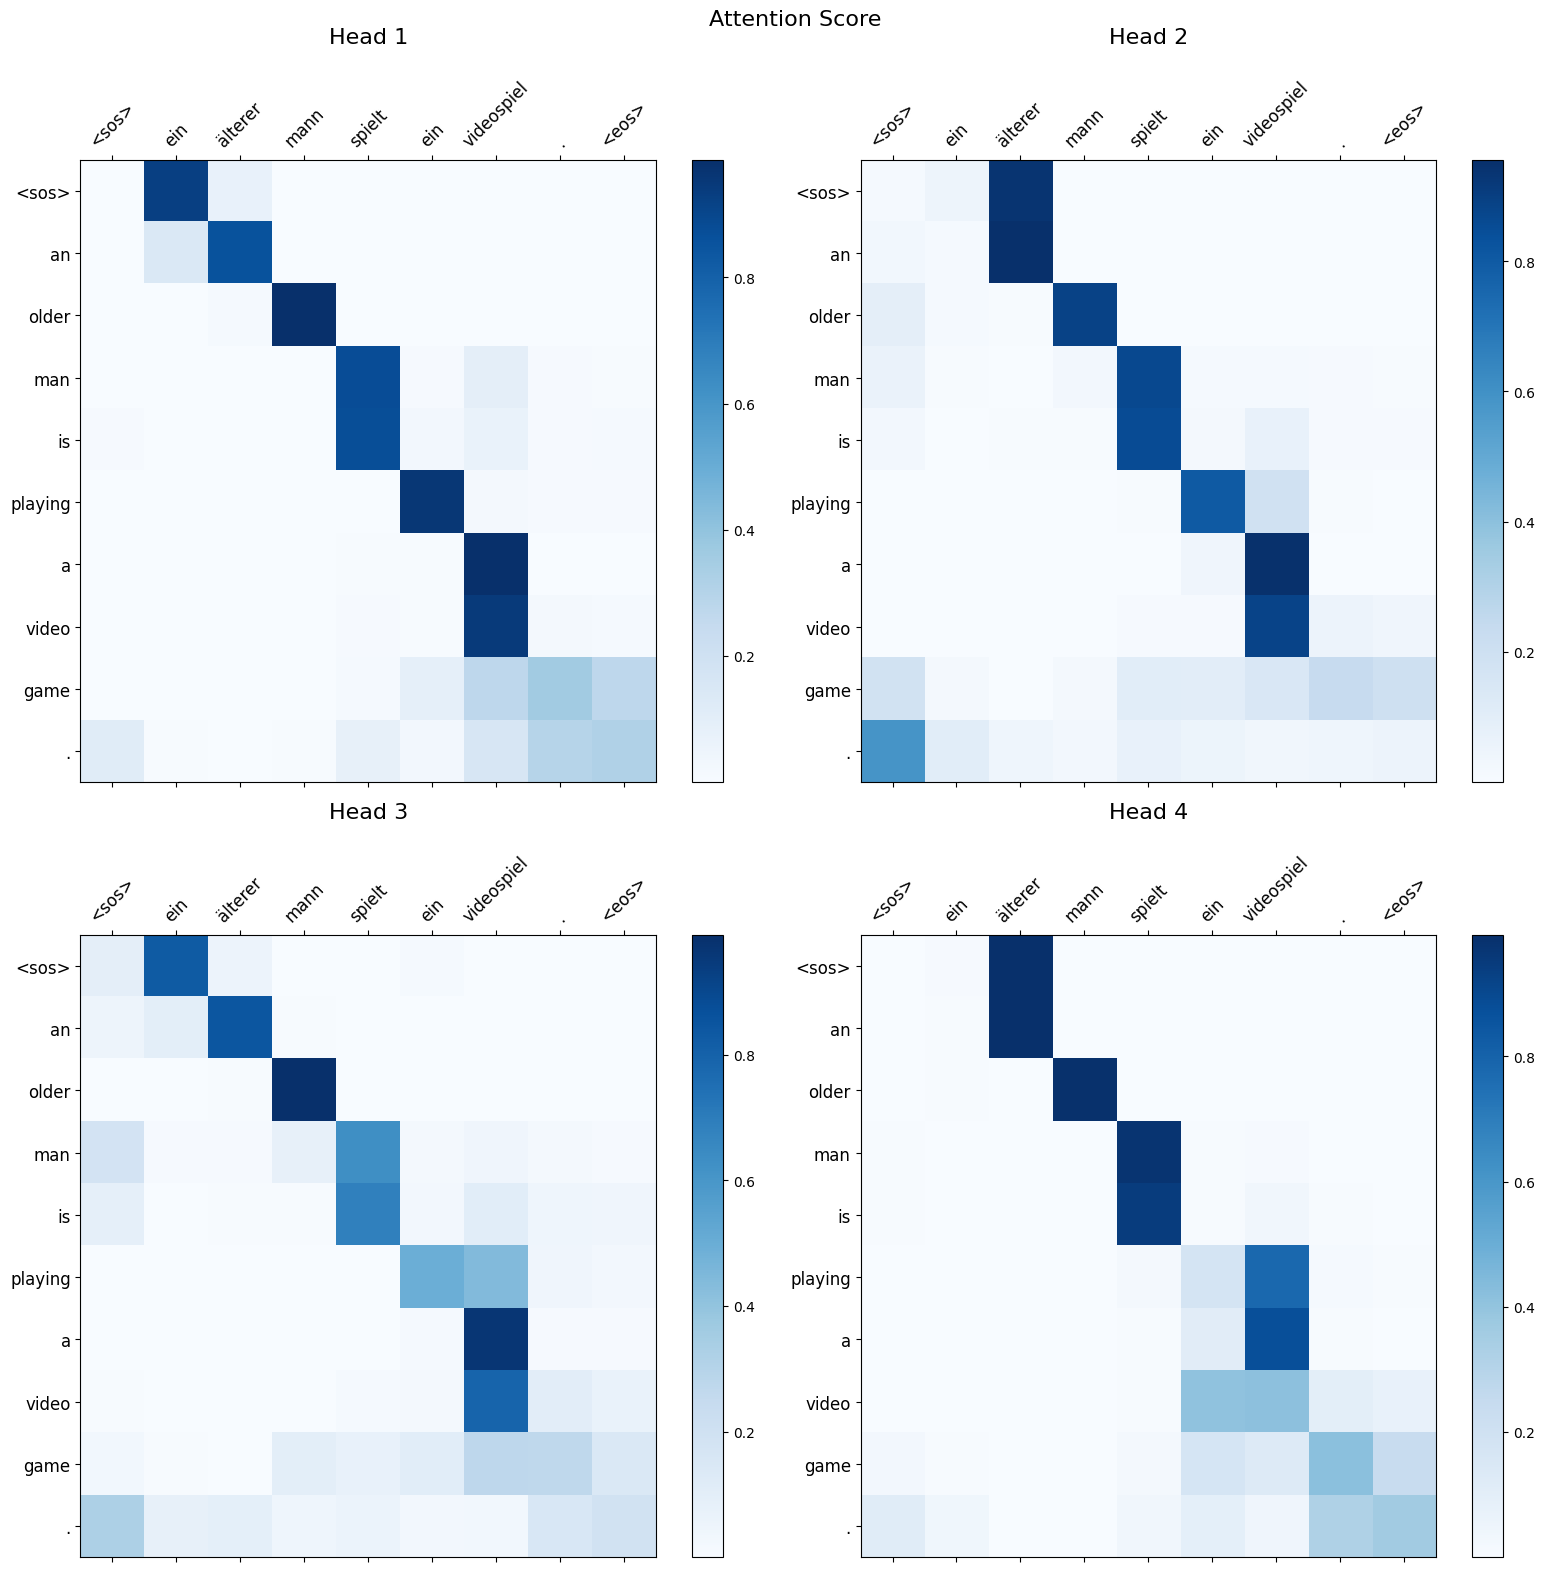

In [ ]:
# Attention score
idx = 998 # random

src = vars(test_data.examples[idx])['src']
trg = vars(test_data.examples[idx])['trg']

print(f"src: {src}")
print(f"trg: {trg}")

translate, attn = machine_translation(src, SRC, TRG, model, device)
print(f"translate: {translate}")
visualize_attention(src, translate, attn, N_HEADS, 2, N_HEADS // 2)